https://github.com/haroldsultan/MCTS  
を参照。

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
nb_mesh = 5
nb_line = 4
budget = 100
SCALAR = 1. / np.sqrt(2.)
#SCALAR = 0.

In [3]:
import copy

def get_permitted_actions(state):
    '''
    ○ および × が置かれていない座標インデックスを返す。
    '''
    return np.where(state[:,:,0]+state[:,:,1]==0)


def transition(current_state, action):
    '''
    action は ○ もしくは × を置く state のインデックス。
    3チャンネル目が手番を表しているので、遷移後は手番を入れ替える。
    '''
    next_state = copy.deepcopy(current_state)
    if current_state[:,:,-1][0,0]==0: # ○の手番の場合
        next_state[action+(0,)] = 1
        next_state[:,:,-1] = np.ones((nb_mesh,nb_mesh))
    else: # ×の手番の場合
        next_state[action+(1,)] = 1
        next_state[:,:,-1] = np.zeros((nb_mesh,nb_mesh))
    return next_state


def judge_game(state):
    winner = None
    
    try:
        for i in range(state.shape[0]):
            for j in range(state.shape[1]):
                s = state[i,j,:2].argmax(-1)

                # 右側をチェック
                count = 0
                for jj in range(j,min(j+nb_line,state.shape[1])):
                    if state[i,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                    
                # 下側をチェック
                count = 0
                for ii in range(i,min(i+nb_line,state.shape[0])):
                    if state[ii,j,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
                # 右下をチェック
                count = 0
                for ii,jj in zip(range(i,min(i+nb_line,state.shape[0])),range(j,min(j+nb_line,state.shape[1]))):
                    if state[ii,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
                # 左下をチェック
                count = 0
                for ii,jj in zip(range(i,max(i-nb_line,0)-1,-1),range(j,min(j+nb_line,state.shape[1]))):
                    if state[ii,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
    except Exception as e:
#        print('=== エラー内容 ===')
#        print('type:' + str(type(e)))
#        print('args:' + str(e.args))
#        print('message:' + e.message)
#        print('e自身:' + str(e))
        pass
    
    return winner

In [4]:
class State(object):
    def __init__(self, state_array):
        self.state_array = state_array
        
        
    def next_state(self):
        acceptable_action = get_permitted_actions(self.state_array)
        random_idx = np.random.randint(0,len(acceptable_action[0]))
        random_action = (acceptable_action[0][random_idx], acceptable_action[1][random_idx])
        return State(transition(self.state_array, random_action))
        
        
    def terminal(self):
        winner = judge_game(self.state_array)
        if winner is not None:
            return True

        acceptable_action = get_permitted_actions(self.state_array)
        if len(acceptable_action[0]) == 0:
            return True
        
        return False
    
    
    def reward(self, root):
        '''
        TODO: 相手の勝利を妨害したことによる報酬
        '''
        winner = judge_game(self.state_array)
        if winner is None:
#            r = 0.
            r = 0.5
        else:
            who_is_root = root.state.state_array[0,0,-1].astype(np.int32)
            if winner==who_is_root:
                r = 1.
            else:
#                r = -1.
                r = 0.
        return r

class Node(object):
    def __init__(self, state, parent=None):
#        self.visits = 1 # 訪問回数
        self.visits = 0 # 訪問回数
        self.reward = 0. # ノード価値
        self.state = state # ノード状態。Stateインスタンス。
        self.children = [] # 子ノードのリスト。リストの要素はNodeインスタンス。
        self.parent = parent # 親ノード。Nodeインスタンス。
        self.expanded_action = [] 
        
        
    def add_child(self, child_state):
        child = Node(child_state, self)
        self.children.append(child)
        
        
    def update(self, reward):
        self.reward += reward
        self.visits += 1
        
        
    def fully_expanded(self):
        acceptable_action = get_permitted_actions(self.state.state_array)
        if len(self.children)==len(acceptable_action[0]):
            return True
        return False

In [5]:
import math
import random

def UCTSEARCH(budget, root):
    '''
    <TREEPOLICY>
    ルートノードから始めてスコアの高い子ノードをたどる。
    もし途中で expand 可能なノードがあれば、そのノードは expand する。
    スコアの最も高い末端ノードまたは expand して得られた新たなノードが front。

    <DEFAULTPOLICY>
    front から先は play out して終端までたどり着く。
    たどり着いた先のノードの状態で得られる報酬が reward。

    <BACKUP>
    front から初めてルートノードに到るまで道中を遡りながら、
    道中のノードの訪問回数と価値を更新していく。
    価値の更新は単純に終端ノードの reward を足すだけ。
    '''
#    plt.figure(figsize=(15,35))
    
    for iter in range(int(budget)):
        front = TREEPOLICY(root)
        reward, final_state = DEFAULTPOLICY(root, front.state)
        BACKUP(front,reward)
        
#        plt.subplot(20,10,2*iter+1)
#        show_state(front.state.state_array)
#        plt.subplot(20,10,2*iter+2)
#        show_state(final_state.state_array)
#        plt.title(reward)
#    plt.show()
    return BESTCHILD(root,0)

    
def TREEPOLICY(node):
    '''
    ルートノードから始めて以下の判定を繰り返しながら子ノードへ深く潜る。
　    　 |_ expand 可能　：　expand して新たな子ノードを得て終了。
       　　　　　　　　　 　　　　　　　　　　　　　　　　　（TREEPOLICY を終えて play out に移る）
  　 　  |_ expand 不可　： 子ノードの中から最もスコアの高いノードを探し出し、その子ノードへ行く。
    '''
    while node.state.terminal()==False:
        if node.fully_expanded()==False:
            return EXPAND(node)
        else:
            node = BESTCHILD(node, SCALAR)
            
#        if len(node.children)==0:
#            return EXPAND(node)
#        elif random.uniform(0,1)<.5:
#            node=BESTCHILD(node,SCALAR)
#        else:
#            if node.fully_expanded()==False:
#                return EXPAND(node)
#            else:
#                node=BESTCHILD(node,SCALAR)
    return node


def EXPAND(node):
    '''
    1. node が取り得る行動からランダムに行動を選択。
    2. 状態遷移させて、遷移後の状態(new_state)を獲得。
    3. 子ノードの状態（tried_children）と重複しているかどうかをチェック。
      |_ 重複していた　　　　　　　　　　：　もう一度ランダムに行動を選ぶ。
      |_ 重複していなかった　：　遷移後の状態(new_state)を新たな子ノードの状態とする。
    '''
    tried_children = [c.state.state_array for c in node.children] # それぞれの子ノードの状態
    new_state = node.state.next_state() # 自身の次の状態をランダムに決める
    try:
        while True:
            identity = []
            for child_state_array in tried_children:
                identity.append(np.all(new_state.state_array==child_state_array))
            if np.array(identity).sum():
                new_state = node.state.next_state()
            else:
                raise Exception
    except Exception:
        pass
#    while new_state.state_array in tried_children: # すでに存在している子ノードの状態と被らないような新しい状態を探し出す
#        new_state = node.state.next_state()
    node.add_child(new_state) # 新しい次の状態を子ノードに加える
    return node.children[-1] # 新しく加えた子ノードを返す


def BESTCHILD(node, scalar):
    '''
    最もスコアの高い子ノードを返す。
    同スコアのノードがある場合は、その中からランダムに選んで返す。
    '''
    bestscore = -1e100
    bestchildren=[]
    for c in node.children:
        exploit = c.reward / float(c.visits)
        explore = math.sqrt(2. * math.log(node.visits) / float(c.visits))
        score = exploit + scalar * explore
        if score==bestscore:
            bestchildren.append(c)
        if score>bestscore:
            bestchildren = [c]
            bestscore = score
    return random.choice(bestchildren)


def DEFAULTPOLICY(root, state):
    '''
    play out のこと。ランダムに行動してとりあえず終端状態までたどり着く。
    '''
    while state.terminal()==False:
        state = state.next_state()
    return state.reward(root), state


def BACKUP(node, reward):
    '''
    node からルートノードへ遡りながら、途中のノードの訪問回数と報酬を加算していく。
    '''
    discount = 1.
    while node!=None:
        node.visits += 1
        node.reward += reward
        reward = - discount * reward # ２人対戦ゲームの場合、1つ上のノードは対戦相手の状態を持っているので、報酬は負。
        node = node.parent
    return

In [6]:
def show_state(state):
    board = np.zeros((nb_mesh,nb_mesh))
    board += state[:,:,0]
    board -= state[:,:,1]
    plt.imshow(board, 'RdBu_r')
    plt.clim(-1,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, nb_mesh, 1))
    ax.set_yticks(np.arange(0, nb_mesh, 1))
    ax.set_xticks(np.arange(-.5, nb_mesh+.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, nb_mesh+.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    plt.tick_params(labelbottom=False, labelleft=False)

[-1.  -0.5 -1.  -1.  -2.  -1.   0.  -2.  -0.5 -1.  -1.  -1.  -1.  -1.
 -1.  -1.5 -1.  -2.  -1.  -2.  -1.   0.  -2.  -2.  -1. ] [4, 7, 3, 3, 3, 3, 7, 3, 6, 3, 4, 3, 3, 3, 5, 3, 4, 3, 5, 3, 4, 8, 3, 3, 4]
[-1.  -1.  -1.5  0.  -1.   0.5 -0.5 -0.5 -1.  -1.  -1.  -1.  -1.  -1.
  0.  -1.  -1.5 -1.  -1.  -2.  -0.5 -1.  -1.  -1. ] [3, 3, 4, 6, 3, 7, 6, 5, 3, 6, 3, 4, 3, 3, 6, 6, 5, 3, 3, 3, 6, 3, 3, 3]
[-1.  -1.5 -2.  -2.  -1.  -1.5 -1.  -1.  -1.5 -1.  -2.  -2.  -1.5 -2.
 -0.5 -2.  -1.  -2.   0.  -1.  -1.  -1.  -1. ] [4, 4, 3, 4, 4, 5, 4, 5, 3, 6, 4, 3, 5, 4, 6, 4, 4, 3, 7, 4, 5, 4, 5]
[-0.5 -1.5 -2.  -1.   0.  -1.  -2.  -1.  -1.  -1.  -2.  -1.  -1.5 -1.
 -1.  -1.5 -2.  -1.5 -1.  -1.  -2.  -1. ] [6, 4, 5, 4, 7, 5, 4, 4, 5, 4, 3, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4]
[-1.5 -2.  -1.  -1.5 -2.  -1.5 -1.  -1.  -2.  -2.  -2.  -1.5 -2.  -1.5
 -1.  -1.  -1.5 -2.  -2.  -1.5 -0.5] [4, 5, 6, 3, 6, 3, 6, 5, 4, 4, 4, 7, 4, 5, 5, 5, 4, 3, 5, 3, 9]
[-2.  -1.5  0.  -2.  -1.  -2.  -1.  -1.  -2.  -1.  -2.  -2.   0.

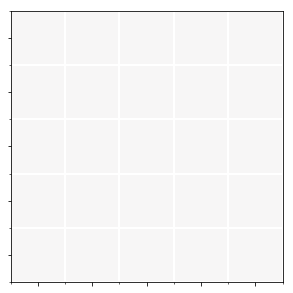

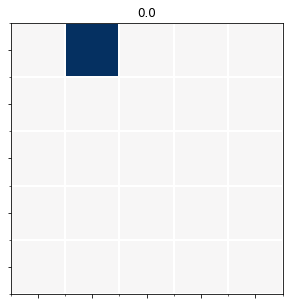

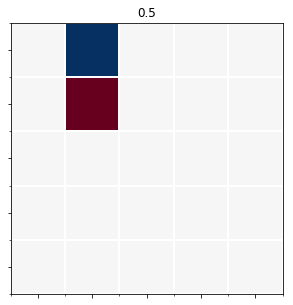

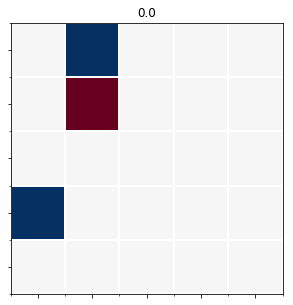

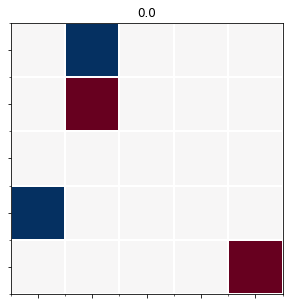

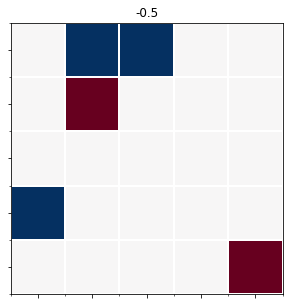

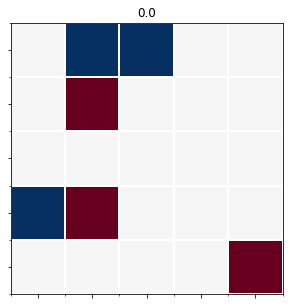

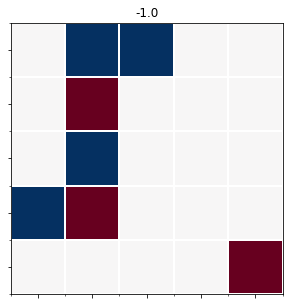

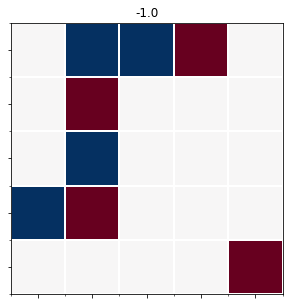

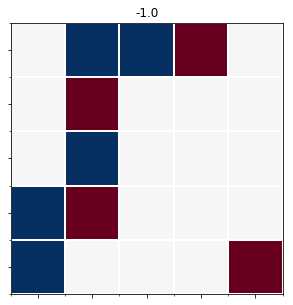

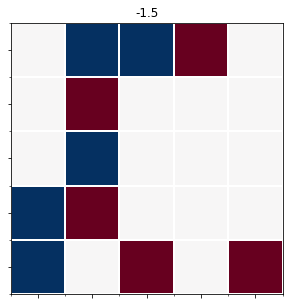

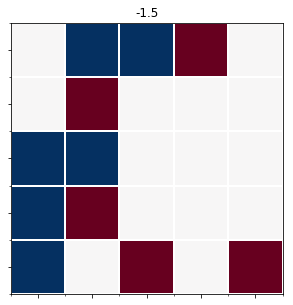

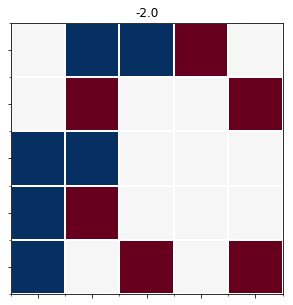

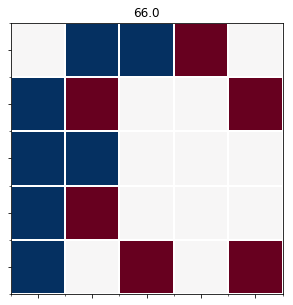

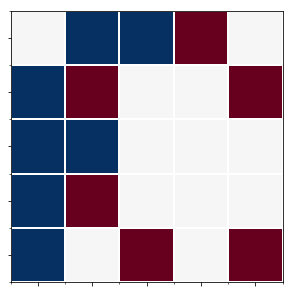

In [7]:
# 状態の初期化
initial_state_array = np.zeros((nb_mesh,nb_mesh,3))
initial_state_array[:,:,-1] = np.random.randint(0,2) # ランダムに先手を決める。
current_state = State(initial_state_array)

#plt.figure(figsize=(5,4*nb_mesh*nb_mesh//2))

previous_reward = None

foo = []
try:
    for nb_move in range(nb_mesh*nb_mesh):

        # ルートノード　＝　現在の盤面とする。
        root_state = current_state
        root = Node(root_state)

#        plt.subplot(nb_mesh*nb_mesh//2+1,2,nb_move+1)

        plt.figure(figsize=(5,5))
        show_state(root_state.state_array)
        foo.append(root_state.state_array)
        if previous_reward is not None:
            plt.title(previous_reward)

        if judge_game(root_state.state_array) is not None:
            raise Exception
            
        # モンテカルロ木探索
        UCTSEARCH(budget, root)

        #　それぞれの子ノードが得た報酬のリスト
        children_rewards = np.array([child.reward for child in root.children])
        previous_reward = children_rewards.max()
        print(children_rewards,[child.visits for child in root.children])

        # 最も得られた報酬が高かった子ノードへ遷移する。
        next_state = root.children[children_rewards.argmax()].state
#        next_state = root.children[(np.array(children_rewards)/np.array([child.visits for child in root.children])).argmax()].state
        current_state = next_state
        
except Exception:
    pass

#plt.subplot(nb_mesh*nb_mesh//2+1,2,nb_move+2)
plt.figure(figsize=(5,5))
show_state(current_state.state_array)

None


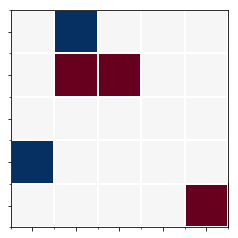

In [8]:
import copy

p = copy.deepcopy(foo[4])
p[1,2,0] = 1
p[:,:,-1] = 1-p[:,:,-1]
show_state(p)
plt.tick_params(labelbottom=False,labelleft=False)
print(judge_game(p))